In [181]:
set.seed(0)

library(MASS)
library(mnormt)
#library(metR)
library(tidyverse)

dev.off()

#https://stats.stackexchange.com/questions/71260/what-is-the-intuition-behind-conditional-gaussian-distributions

null device 
          1

# 0 Set the scene

Imagine that we have a 3 sided die. Let's roll it 300 times and record the outcome:

In [191]:
set.seed(0)
table(sample(c('a','b','c'), size=300, p=c(1/3,1/3,1/3), replace = TRUE))


  a   b   c 
 90 101 109 

How do we calculate the probability of getting a result as extreme or more as (90, 101, 109) in the long-run?

# 1 Probability via simulation

## 1.1 Simulate the distribution

Let's repeat the above process 100,000 times and record the results. Here's what the first 3 out of 100,000 results look like:

In [5]:
set.seed(0)
m <- replicate(n = 100000, table(sample(c('side1','side2','side3'), size=300, p=c(1/3,1/3,1/3), replace = TRUE))) %>%
t() %>%
data.frame()

m %>% head(3)

,side1,side2,side3
,<int>,<int>,<int>
1,90,101,109
2,104,86,110
3,108,92,100


## 1.2 Degrees of freedom

Even though the die has 3 sides, we don't need to record the count of *all 3* sides. If we know that out of 300 rolls we got 90 counts of side 1 and 101 counts of side 2, then the count of side 3 *must* be 109. The count of side 3 doesn't have the *freedom* to be anything else other than 109. So this system has 2 degrees of freedom and we lose no information by removing the the column representing side 3 from the results:

In [6]:
m1 <- m %>% dplyr::select(side1, side2)
m1 %>% head(3)

,side1,side2
,<int>,<int>
1,90,101
2,104,86
3,108,92


## 1.3 Visualize the distribution

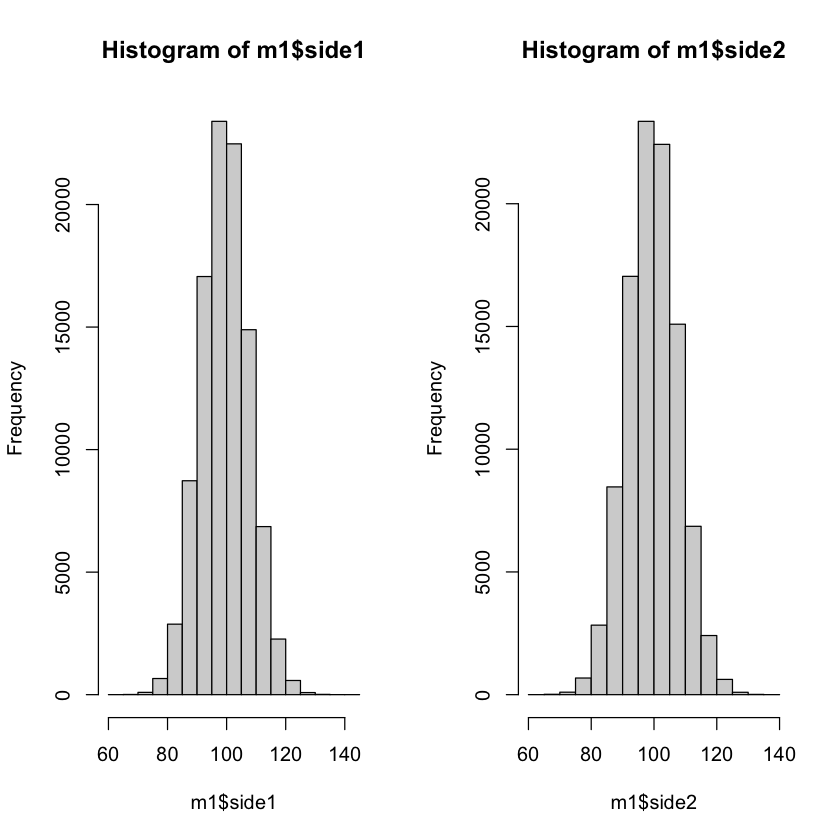

In [7]:
par(mfrow = c(1, 2))
hist(m1$side1)
hist(m1$side2)

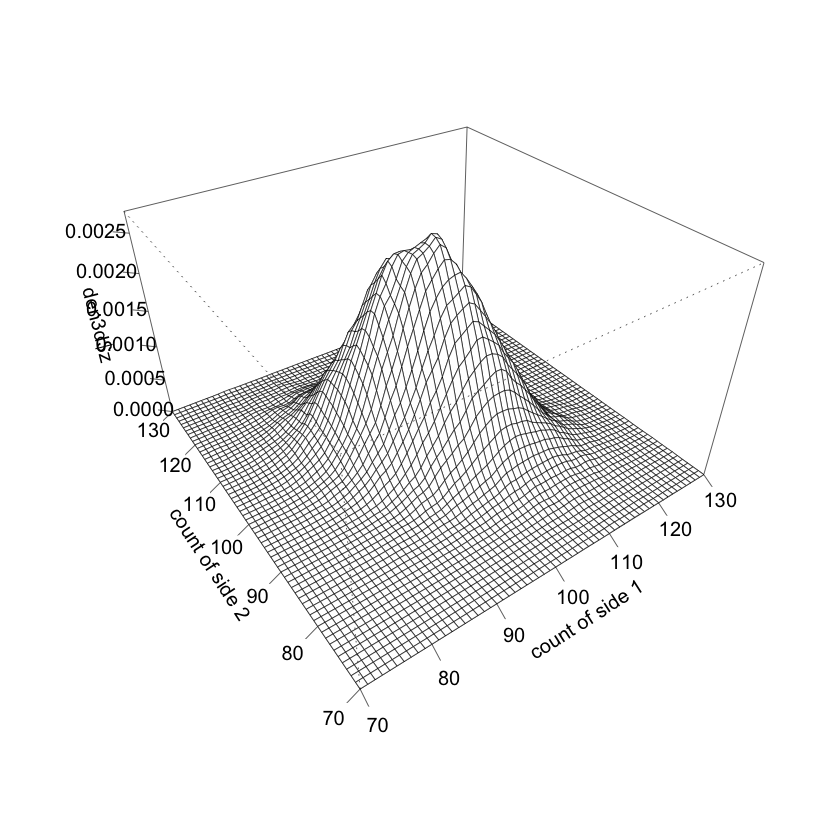

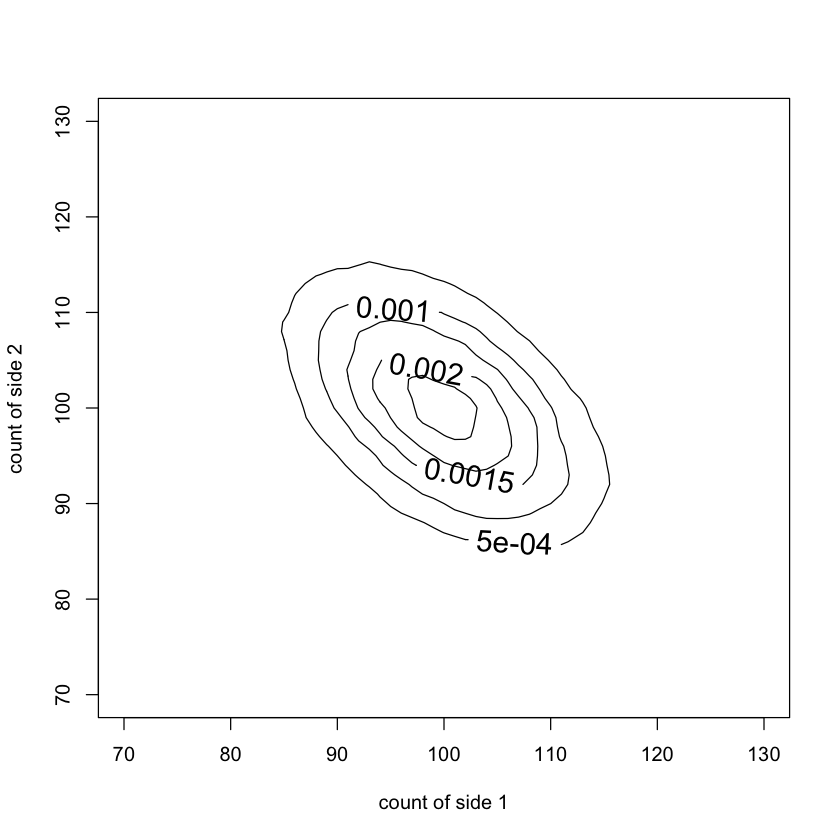

In [68]:
m2 <- m1 %>% filter(between(side1, 70, 130) & between(side2, 70, 130))
den3d <- kde2d(m2$side1, m2$side2, n=61)

persp(x=den3d$x, y=den3d$y, z=den3d$z, 
      theta=325, phi=35, expand=0.6, ticktype='detailed', border = 'black', lwd=0.5, 
      xlab = 'count of side 1', ylab = 'count of side 2')

contour(den3d$x,den3d$y,den3d$z, xlab = 'count of side 1', ylab = 'count of side 2', nlevels = 5, labcex=1.5)

## 1.4 Observe the target outcome within the distribution

Let's return to our question of how to calculate the probability of getting a result as extreme or more as (90, 101, 109). Let's find this point in our distribution:

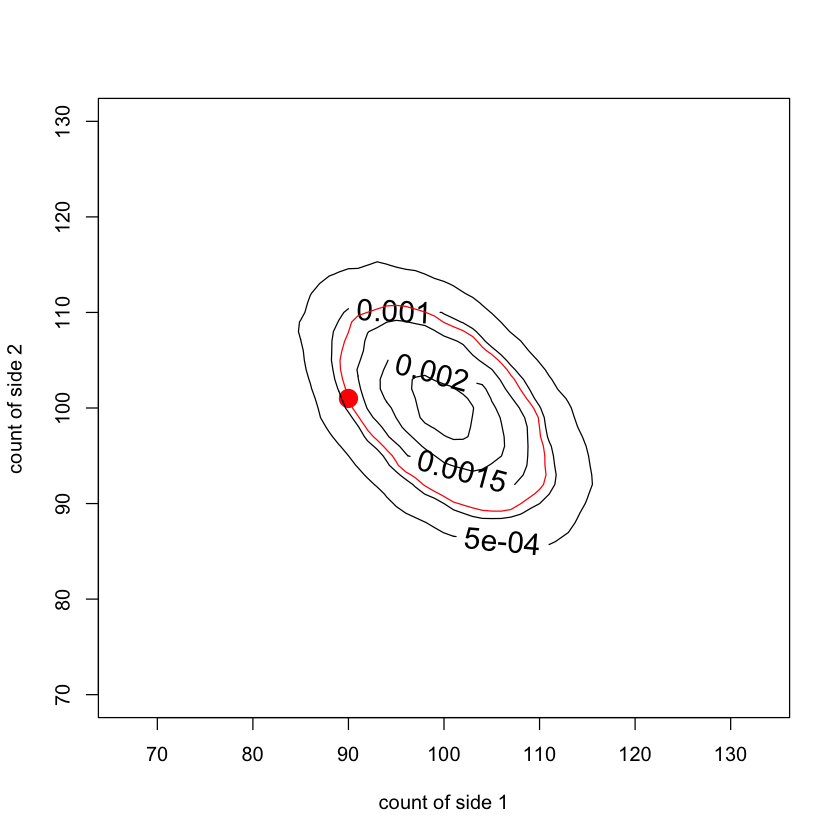

In [71]:
tgt.x.pos <- match(c(90),den3d$x)
tgt.y.pos <- match(c(101),den3d$y)
tgt.z.den <- den3d$z[tgt.x.pos,tgt.y.pos]

plot(x=90, y=101, xlim = c(70, 130), ylim = c(70, 130), asp=1, col='red', pch=19, cex = 2, xlab = 'count of side 1', ylab = 'count of side 2')
contour(den3d$x,den3d$y,den3d$z, add=TRUE, nlevels=5, labcex=1.5)
contour(den3d$x,den3d$y,den3d$z, levels=c(tgt.z.den), drawlabels = FALSE, add=TRUE, col='red')

## 1.5 Compute the probability of observing each unique outcome in our data set

From the contour plot above, it becomes obvious that the point (90, 101) lies on a contour which contains other equally-probable points. Every point inside the contour has a higher probability of occurring. Every point on or beyond the contour has an equal or lower probability of occurring.

Let's first compute the frequency of each unique observation within our data set:

In [80]:
m3 <- m1 %>% 
group_by(side1, side2) %>%
summarise(freq=n()) %>% 
ungroup() %>%
arrange(-freq)

m3 %>% head(3)

`summarise()` has grouped output by 'side1'. You can override using the
`.groups` argument.


side1,side2,freq
<int>,<int>,<int>
102,100,310
101,101,287
101,100,285


Now, let's look up (90, 101) in our table:

In [82]:
m3 %>% filter(side1 == 90 & side2==101)

side1,side2,freq
<int>,<int>,<int>
90,101,119


This outcome occured only 119 times out of 100,000 random observations.

Now let's keep only the observations that occurred with a frequency of 119 or lower:

In [ ]:
m4 <- m3 %>% filter(freq <= 119)

And let's visualize the results:

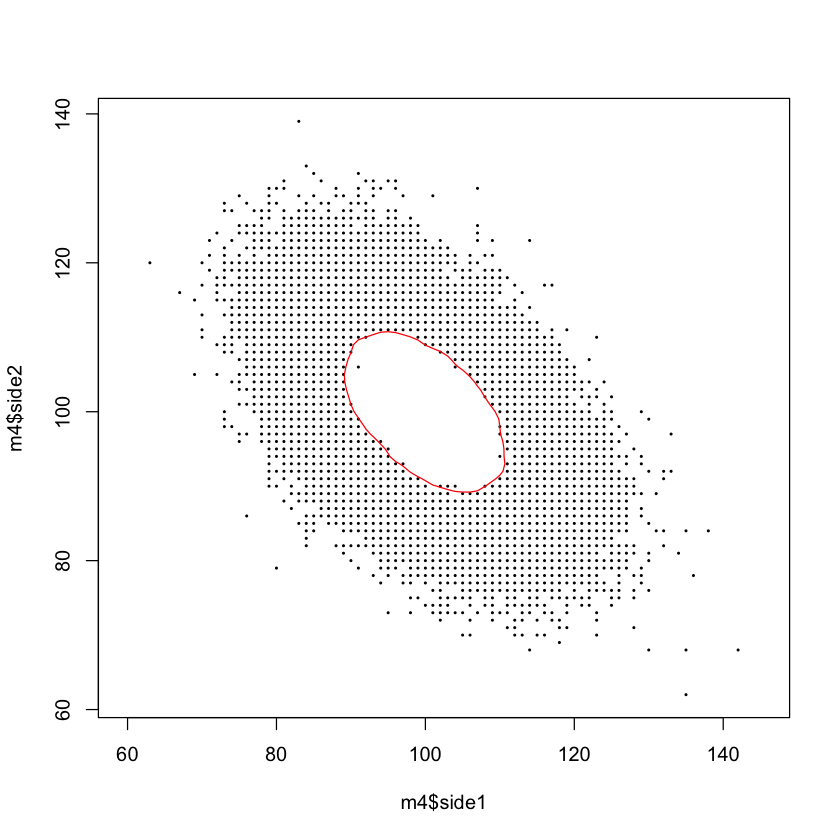

In [98]:
plot(x=m4$side1, y=m4$side2, pch=19, cex = .2, asp=1)
contour(den3d$x,den3d$y,den3d$z, levels=c(tgt.z.den), drawlabels = FALSE, add=TRUE, col='red')

## 1.6 Compute the probability of getting a result as extreme or more as (90, 101)

In [95]:
m4 %>% summarise(sum(freq)) %>% pull()

[1] 43316

There are 43,316 / 100,000 rows in our simulation whose results are at least as extreme as (90, 101). That is to say, the estaimated p-value of observing the result (90, 109) is ~0.43.

# 2 Probability via the chi squared test

The simulation was a useful tool for understanding how the distribution arises. Now that we understand this we can switch gears and create the distribution without the need of simulation. We just need to know 3 properties:
1. The means of the marginal distributions
1. The variance within each distribution
1. The covarince between each distribution

The mean of each distribution is equal to $$ \mu{_x} = n * p{_x} $$$$ \mu{_y} = n * p{_y} $$

In [229]:
mean.x <- 300 * 1/3
mean.y <- 300 * 1/3
mean.x
mean.y

[1] 100

[1] 100

The variance of each distribution is equal to $$ \sigma{_x}^2=n * p{_x} * (1-p{_x}) $$$$ \sigma{_y}^2=n * p{_y} * (1-p{_y}) $$

In [230]:
var.x <- 300 * 1/3 * (1 - 1/3)
var.y <- 300 * 1/3 * (1 - 1/3)
var.x
var.y

[1] 66.66667

[1] 66.66667

The covariance between each distribution is equal to $$ Cov(X, Y) = \frac{-n}{ k^2} $$

In [231]:
cov <- -300 / 3^2
cov

[1] -33.33333

The correlation coefficient is equal to $$ \rho = \frac{Cov(X, Y)}{\sigma{_x}\sigma{_y}}$$

In [232]:
rho <- cov / (sqrt(var.x) * sqrt(var.y))
rho

[1] -0.5

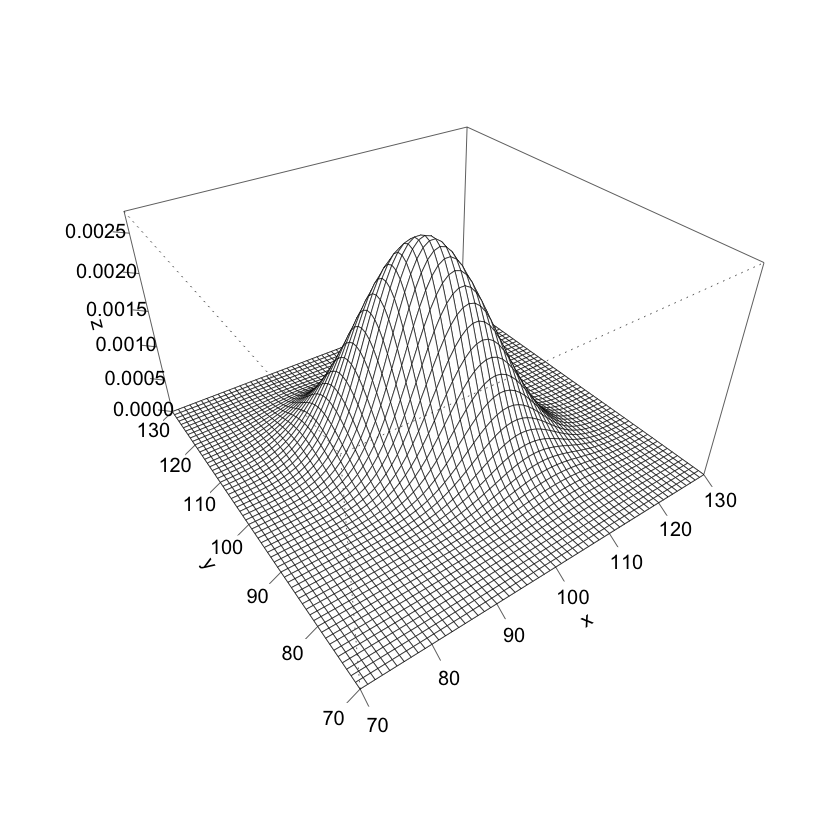

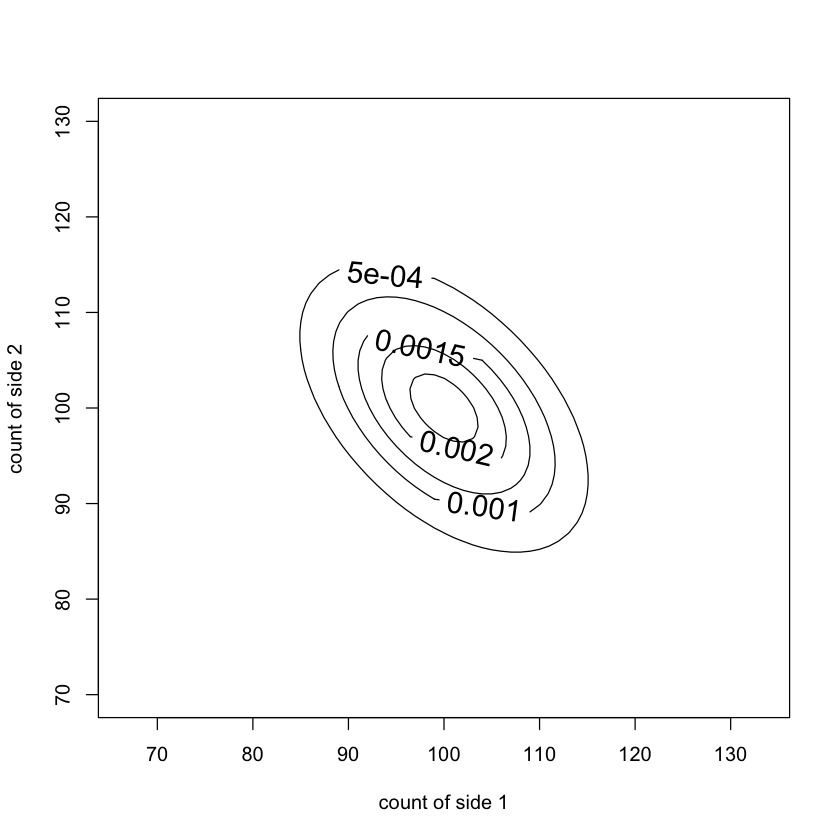

In [233]:
set.seed(0)

#create bivariate normal distribution
x     <- seq(70, 130, 1) 
y     <- seq(70, 130, 1)
mu    <- c(mean.x, mean.y)
sigma <- matrix(c(var.x, cov, cov, var.y), nrow=2)
f     <- function(x, y) dmnorm(cbind(x, y), mu, sigma)
z     <- outer(x, y, f)

#create surface plot
persp(x, y, z, theta=325, phi=35, expand=0.6, ticktype='detailed', border = 'black', lwd=0.5)
contour(x,y,z, xlab = 'count of side 1', ylab = 'count of side 2', nlevels = 5, labcex=1.5, asp=1)

In [234]:
z

5.181193e-15,1.261688e-14,3.011536e-14,7.045930e-14,1.615856e-13,3.632297e-13,8.003389e-13,1.728545e-12,3.659330e-12,7.593404e-12,⋯,2.251889e-06,1.977374e-06,1.701941e-06,1.435868e-06,1.187404e-06,9.624910e-07,7.647315e-07,5.955735e-07,4.546486e-07,3.401970e-07
1.261688e-14,3.041802e-14,7.188268e-14,1.665067e-13,3.780533e-13,8.413732e-13,1.835432e-12,3.924661e-12,8.225837e-12,1.689943e-11,⋯,3.292903e-06,2.862712e-06,2.439442e-06,2.037593e-06,1.668240e-06,1.338794e-06,1.053133e-06,8.120198e-07,6.137114e-07,4.546486e-07
3.011536e-14,7.188268e-14,1.681801e-13,3.856905e-13,8.669968e-13,1.910338e-12,4.125883e-12,8.734494e-12,1.812478e-11,3.686564e-11,⋯,4.719814e-06,4.062382e-06,3.427289e-06,2.834228e-06,2.297380e-06,1.825346e-06,1.421581e-06,1.085206e-06,8.120198e-07,5.955735e-07
7.045930e-14,1.665067e-13,3.856905e-13,8.757103e-13,1.948929e-12,4.251535e-12,9.090955e-12,1.905406e-11,3.914529e-11,7.882893e-11,⋯,6.631092e-06,5.650644e-06,4.719814e-06,3.864257e-06,3.101139e-06,2.439442e-06,1.880936e-06,1.421581e-06,1.053133e-06,7.647315e-07
1.615856e-13,3.780533e-13,8.669968e-13,1.948929e-12,4.294263e-12,9.274605e-12,1.963434e-11,4.074284e-11,8.287057e-11,1.652203e-10,⋯,9.131860e-06,7.704229e-06,6.371083e-06,5.164299e-06,4.103209e-06,3.195583e-06,2.439442e-06,1.825346e-06,1.338794e-06,9.624910e-07
3.632297e-13,8.413732e-13,1.910338e-12,4.251535e-12,9.274605e-12,1.983167e-11,4.156590e-11,8.539436e-11,1.719631e-10,3.394342e-10,⋯,1.232672e-05,1.029614e-05,8.429770e-06,6.765049e-06,5.321576e-06,4.103209e-06,3.101139e-06,2.297380e-06,1.668240e-06,1.187404e-06
8.003389e-13,1.835432e-12,4.125883e-12,9.090955e-12,1.963434e-11,4.156590e-11,8.625258e-11,1.754370e-10,3.497715e-10,6.835365e-10,⋯,1.630985e-05,1.348758e-05,1.093282e-05,8.686494e-06,6.765049e-06,5.164299e-06,3.864257e-06,2.834228e-06,2.037593e-06,1.435868e-06
1.728545e-12,3.924661e-12,8.734494e-12,1.905406e-11,4.074284e-11,8.539436e-11,1.754370e-10,3.532867e-10,6.973448e-10,1.349217e-09,⋯,2.115274e-05,1.731840e-05,1.389834e-05,1.093282e-05,8.429770e-06,6.371083e-06,4.719814e-06,3.427289e-06,2.439442e-06,1.701941e-06
3.659330e-12,8.225837e-12,1.812478e-11,3.914529e-11,8.287057e-11,1.719631e-10,3.497715e-10,6.973448e-10,1.362777e-09,2.610456e-09,⋯,2.689040e-05,2.179694e-05,1.731840e-05,1.348758e-05,1.029614e-05,7.704229e-06,5.650644e-06,4.062382e-06,2.862712e-06,1.977374e-06
7.593404e-12,1.689943e-11,3.686564e-11,7.882893e-11,1.652203e-10,3.394342e-10,6.835365e-10,1.349217e-09,2.610456e-09,4.950679e-09,⋯,3.350751e-05,2.689040e-05,2.115274e-05,1.630985e-05,1.232672e-05,9.131860e-06,6.631092e-06,4.719814e-06,3.292903e-06,2.251889e-06
1.544492e-11,3.403128e-11,7.349960e-11,1.555987e-10,3.228798e-10,6.567346e-10,1.309342e-09,2.558765e-09,4.901419e-09,9.202956e-09,⋯,4.092616e-05,3.251721e-05,2.532443e-05,1.933215e-05,1.446554e-05,1.060971e-05,7.627571e-06,5.375058e-06,3.712737e-06,2.513734e-06


## 2.x Make circular

### Mean

In [236]:
mean.x <- 300 * 1/3
mean.y <- ((300 * 1/3) - (rho*mean.x)) / sqrt(1-rho^2)
mean.x
mean.y

[1] 100

[1] 173.2051

### Variance

In [237]:
var.x <- 300 * 1/3 * (1 - 1/3)
var.y <- 300 * 1/3 * (1 - 1/3)
var.x
var.y

[1] 66.66667

[1] 66.66667

### Covariance

In [238]:
cov <- 0
cov

[1] 0

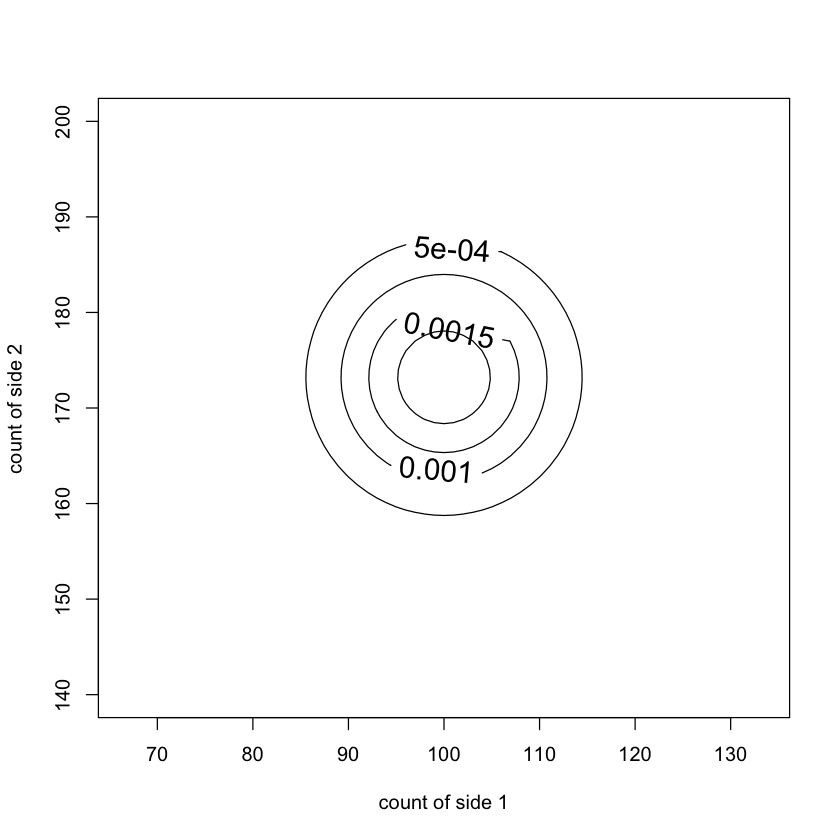

In [239]:
set.seed(0)

#create bivariate normal distribution
x     <- seq(70, 130, 1) 
y     <- seq(140, 200, 1)
mu    <- c(mean.x, mean.y)
sigma <- matrix(c(var.x, cov, cov, var.y), nrow=2)
f     <- function(x, y) dmnorm(cbind(x, y), mu, sigma)
z     <- outer(x, y, f)

#create surface plot
#persp(x, y, z, theta=325, phi=35, expand=0.6, ticktype='detailed', border = 'black', lwd=0.5)
contour(x,y,z, xlab = 'count of side 1', ylab = 'count of side 2', nlevels = 8, labcex=1.5, asp=1)

## 2.x Normalize

### Mean

In [240]:
mean.x <- 0
mean.y <- 0
mean.x
mean.y

[1] 0

[1] 0

### Variance

In [241]:
var.x <- 1
var.y <- 1
var.x
var.y

[1] 1

[1] 1

### Covariance

In [242]:
cov <- 0
cov

[1] 0

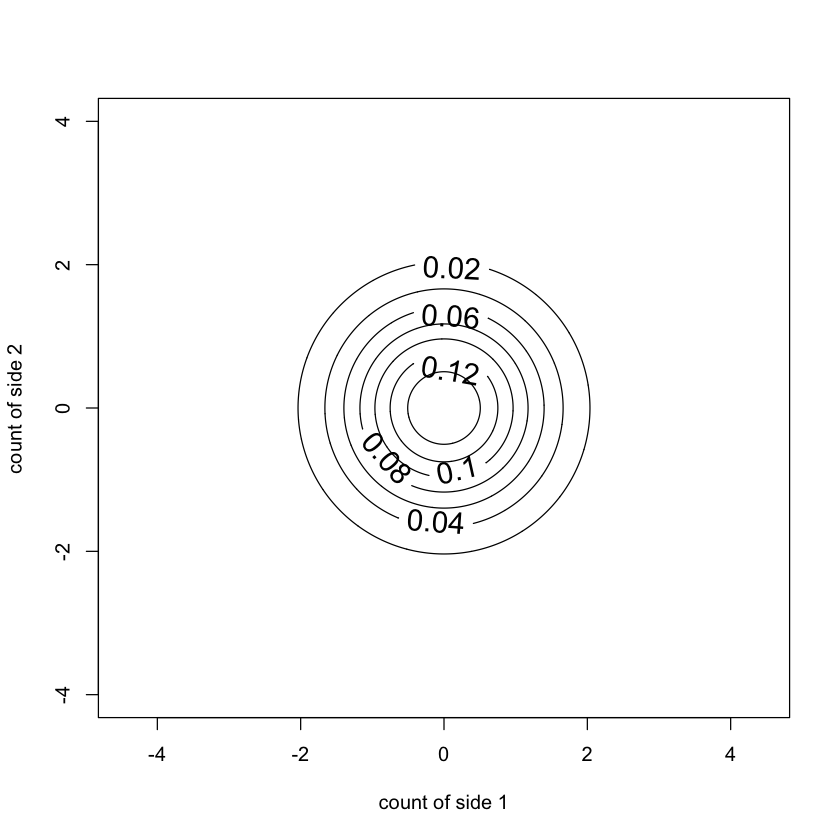

In [243]:
set.seed(0)

#create bivariate normal distribution
x     <- seq(-4, 4, 0.01) 
y     <- seq(-4, 4, 0.01)
mu    <- c(0, 0)
sigma <- matrix(c(var.x, cov, cov, var.y), nrow=2)
f     <- function(x, y) dmnorm(cbind(x, y), mu, sigma)
z     <- outer(x, y, f)

contour(x,y,z, xlab = 'count of side 1', ylab = 'count of side 2', nlevels = 10, labcex=1.5, asp=1)

In [228]:
z

7.163068e-10,1.169913e-09,1.882321e-09,2.983455e-09,4.658335e-09,7.165188e-09,1.085701e-08,1.620608e-08,2.383042e-08,3.452001e-08,⋯,2.600152e-07,1.976141e-07,1.479527e-07,1.091222e-07,7.928468e-08,5.674804e-08,4.001272e-08,2.779270e-08,1.901731e-08,1.281897e-08
1.114999e-09,1.821080e-09,2.930010e-09,4.644027e-09,7.251136e-09,1.115329e-08,1.689995e-08,2.522629e-08,3.709429e-08,5.373364e-08,⋯,4.047380e-07,3.076049e-07,2.303022e-07,1.698590e-07,1.234140e-07,8.833365e-08,6.228355e-08,4.326195e-08,2.960223e-08,1.995393e-08
1.709760e-09,2.792478e-09,4.492933e-09,7.121240e-09,1.111903e-08,1.710267e-08,2.591470e-08,3.868248e-08,5.688109e-08,8.239619e-08,⋯,6.206331e-07,4.716873e-07,3.531499e-07,2.604651e-07,1.892455e-07,1.354525e-07,9.550679e-08,6.633871e-08,4.539263e-08,3.059773e-08
2.582746e-09,4.218289e-09,6.786978e-09,1.075727e-08,1.679629e-08,2.583511e-08,3.914648e-08,5.843335e-08,8.592398e-08,1.244668e-07,⋯,9.375218e-07,7.125259e-07,5.334645e-07,3.934558e-07,2.858722e-07,2.046131e-07,1.442716e-07,1.002106e-07,6.856963e-08,4.622062e-08
3.843384e-09,6.277234e-09,1.009970e-08,1.600789e-08,2.499456e-08,3.844522e-08,5.825387e-08,8.695465e-08,1.278635e-07,1.852191e-07,⋯,1.395126e-06,1.060310e-06,7.938484e-07,5.855015e-07,4.254064e-07,3.044848e-07,2.146905e-07,1.491233e-07,1.020385e-07,6.878089e-08
5.634189e-09,9.202080e-09,1.480560e-08,2.346669e-08,3.664064e-08,5.635857e-08,8.539696e-08,1.274707e-07,1.874408e-07,2.715209e-07,⋯,2.045178e-06,1.554356e-06,1.163738e-06,8.583129e-07,6.236223e-07,4.463579e-07,3.147244e-07,2.186066e-07,1.495828e-07,1.008290e-07
8.136444e-09,1.328891e-08,2.138106e-08,3.388871e-08,5.291348e-08,8.138853e-08,1.233234e-07,1.840830e-07,2.706869e-07,3.921087e-07,⋯,2.953482e-06,2.244676e-06,1.680577e-06,1.239507e-06,9.005853e-07,6.445943e-07,4.544997e-07,3.156940e-07,2.160154e-07,1.456091e-07
1.157507e-08,1.890506e-08,3.041712e-08,4.821074e-08,7.527576e-08,1.157849e-07,1.754424e-07,2.618801e-07,3.850846e-07,5.578216e-07,⋯,4.201681e-06,3.193320e-06,2.390822e-06,1.763346e-06,1.281190e-06,9.170125e-07,6.465803e-07,4.491126e-07,3.073078e-07,2.071464e-07
1.622176e-08,2.649430e-08,4.262776e-08,6.756445e-08,1.054944e-07,1.622656e-07,2.458719e-07,3.670091e-07,5.396728e-07,7.817533e-07,⋯,5.888403e-06,4.475245e-06,3.350593e-06,2.471224e-06,1.795511e-06,1.285138e-06,9.061432e-07,6.294041e-07,4.306733e-07,2.903032e-07
2.239535e-08,3.657736e-08,5.885082e-08,9.327778e-08,1.456430e-07,2.240198e-07,3.394445e-07,5.066836e-07,7.450587e-07,1.079269e-06,⋯,8.129381e-06,6.178410e-06,4.625744e-06,3.411709e-06,2.478837e-06,1.774229e-06,1.250999e-06,8.689395e-07,5.945767e-07,4.007853e-07
3.045814e-08,4.974597e-08,8.003833e-08,1.268597e-07,1.980775e-07,3.046716e-07,4.616516e-07,6.891003e-07,1.013295e-06,1.467828e-06,⋯,1.105613e-05,8.402766e-06,6.291108e-06,4.639996e-06,3.371270e-06,2.412988e-06,1.701384e-06,1.181776e-06,8.086367e-07,5.450764e-07


In [93]:
chisq.test(x = c(90,101,109), p = c(1/3,1/3,1/3), rescale.p = TRUE)


	Chi-squared test for given probabilities

data:  c(90, 101, 109)
X-squared = 1.82, df = 2, p-value = 0.4025


Our result of 0.43316 is close to the chi-squared test probability of 0.4025, but slightly different because:
1. Our simulation is imperfect and hasn't captured every permutation that adds up to 300
1. Our simualtion creates a discrete distribution whereas the chi-squared test is based on a continuous distribution

# 3 Probability via an exact test

# Playground

# 1. Univariate normal distribution <a class="anchor" id="first-bullet"></a>

## 1.1 Real world experiment to approximate the distribution

Let's flip 1 coin 100 times and record the outcome:

In [111]:
set.seed(0)
table(sample(c('heads','tails'), size=100, p=c(0.5, 0.5), replace = TRUE))


heads tails 
   48    52 

Now let's repeat the above process 10,000 times and record the results. Here's what the first 3 out of 10,000 results look like:

In [112]:
set.seed(0)
m <- replicate(n = 10000, table(sample(c('heads','tails'), size=100, p=c(0.5, 0.5), replace = TRUE))) %>%
t() %>%
data.frame()

m %>% head(3)

,heads,tails
,<int>,<int>
1,48,52
2,54,46
3,38,62


## 1.2 Degrees of freedom

Even though the coin has 2 faces, we don't need to record the count of *both* faces. If we know that out of 100 flips we got 48 heads, then the number of tails must be 52. The number of tails doesn't have the *freedom* to be anything else other than 52. So this system has 1 degree of freedom and we lose no information by removing the tails columns from the results:

In [113]:
m <- m %>% select(heads)
m %>% head(3)

,heads
,<int>
1,48
2,54
3,38


## 1.3 Visualize the distribution

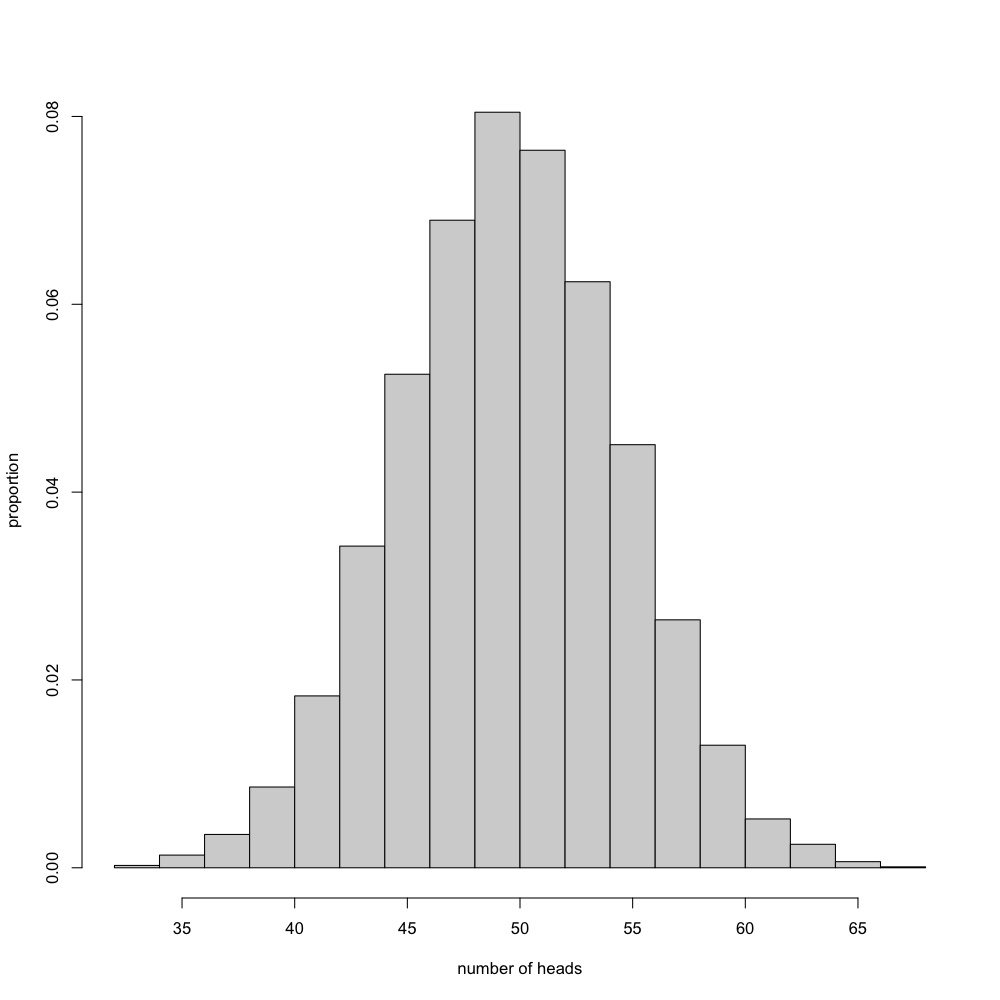

In [114]:
hist(m %>% pull(), freq = FALSE, main=NULL, xlab="number of heads", ylab="proportion")

The resulting distribution is a binomial distribution with the following parameters:
- mean = 50
- se = $\sqrt{n*p*(1-p)} = \sqrt{100*0.5*1-(0.5)} = 5$

## 1.4 Visualize a theoretical, continuous distribution

The above exercise was useful to understand how a univariate normal distribution can be created. If we were to increase:
- the number of coin flips from 100 to $\infty$, and
- the number of simulations from 10,000 to $\infty$ 

... then we'd arrive at the continuous normal distribution, so let's proceed with that.

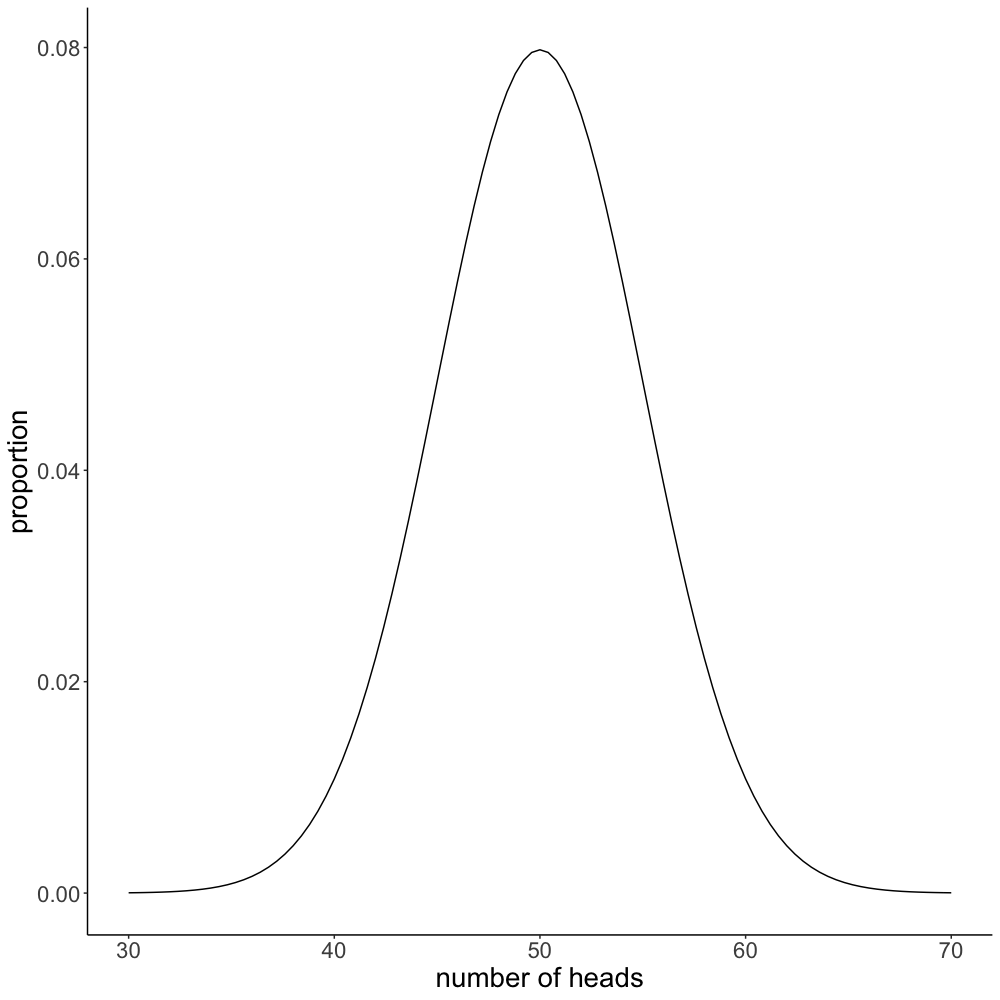

In [216]:
ggplot() + 
scale_x_continuous(limits=c(30,70)) +
stat_function(fun = dnorm, args = list(mean = 50, sd = 5), color = 'black', size=0.5) +
labs(y="proportion", x = "number of heads") +
#theme(text = element_text(size=40)) + 
theme_classic() + 
theme(text = element_text(size=20)) 

## 1.5 Choose a point in this space

Imagine that we wanted to understand the probability of getting a value at least as extreme as 45 heads from 100 coin flips. Since our distribution is symmetrical, we know that the probability of seeing a result <= 45 heads is the same as the probaility of seeing a result >= 55 heads. Let's plot these points on the distribution:

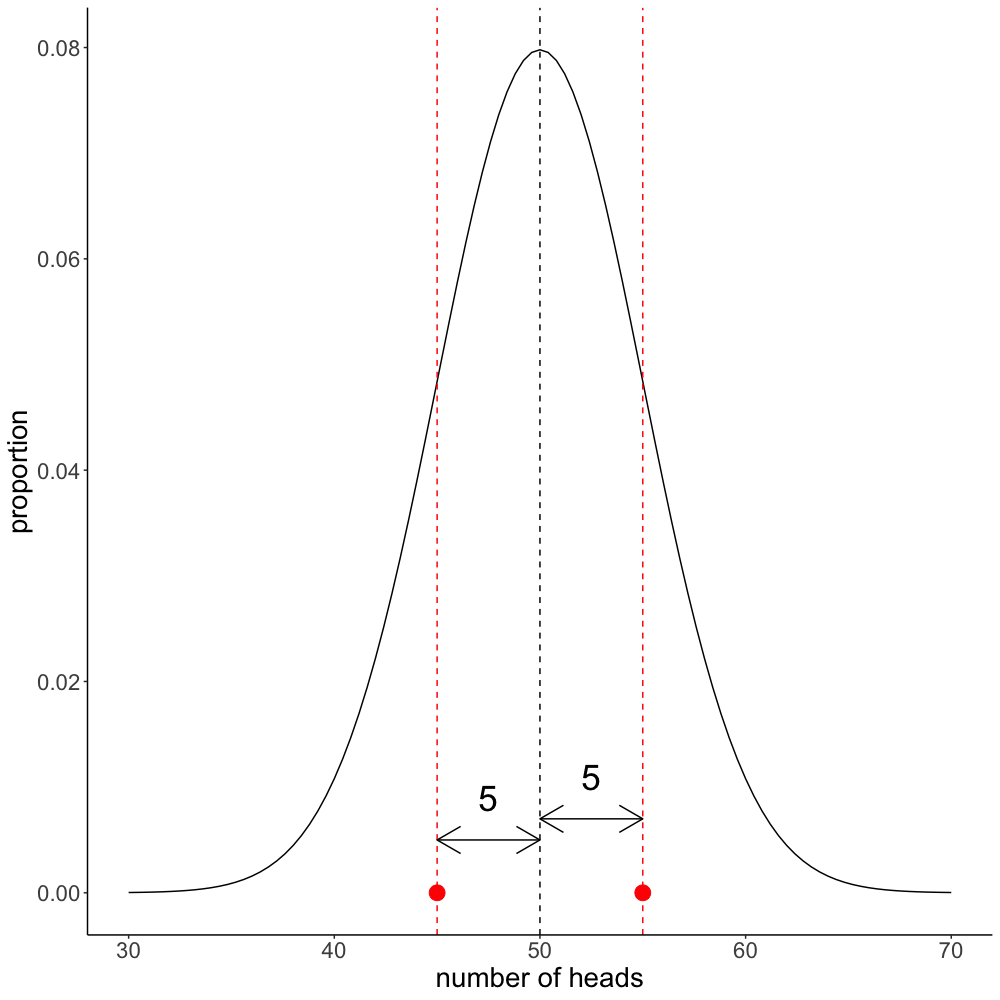

In [217]:
ggplot() + 
scale_x_continuous(limits=c(30,70)) +
stat_function(fun = dnorm, args = list(mean = 50, sd = 5), color = 'black', size=0.5) +

geom_vline(xintercept = 50, color = "black", linetype=2) +
geom_vline(xintercept = c(45, 55), color = "red", linetype=2) +
geom_segment(aes(x = 45, y = 0.005, xend = 50, yend = 0.005),arrow = arrow(length = unit(0.03, "npc"), ends = "both")) +
geom_segment(aes(x = 50, y = 0.007, xend = 55, yend = 0.007),arrow = arrow(length = unit(0.03, "npc"), ends = "both")) +
annotate("text", x = 47.5, y = 0.009, label = "5", size=9) +
annotate("text", x = 52.5, y = 0.011, label = "5", size=9) +
geom_point(aes(x=45, y=0), colour="red", size=5) +
geom_point(aes(x=55, y=0), colour="red", size=5) +




labs(y="proportion", x = "number of heads") + 
theme_classic() + 
theme(text = element_text(size=20)) 

## 1.6 Standardize the distribution

Let's examine the standardized distribution:

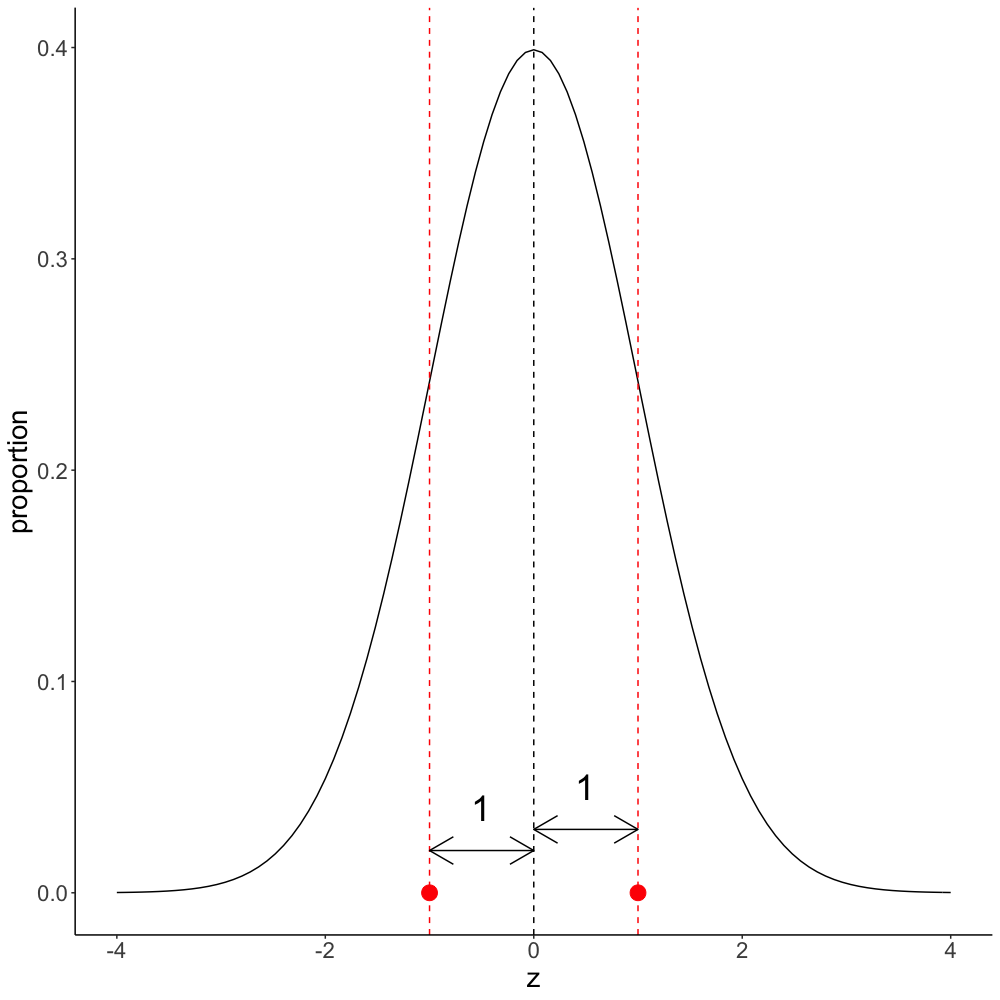

In [219]:
ggplot() + 
scale_x_continuous(limits=c(-4,4)) +
stat_function(fun = dnorm, args = list(mean = 0, sd = 1), color = 'black', size=0.5) +

geom_vline(xintercept = 0, color = "black", linetype=2) +
geom_vline(xintercept = c((45-50)/5, (55-50)/5), color = "red", linetype=2) +
geom_segment(aes(x = -1, y = 0.02, xend = 0, yend = 0.02),arrow = arrow(length = unit(0.03, "npc"), ends = "both")) +
geom_segment(aes(x = 0, y = 0.03, xend = 1, yend = 0.03),arrow = arrow(length = unit(0.03, "npc"), ends = "both")) +
annotate("text", x = -0.5, y = 0.04, label = "1", size=9) +
annotate("text", x = 0.5, y = 0.05, label = "1", size=9) +
geom_point(aes(x=-1, y=0), colour="red", size=5) +
geom_point(aes(x=1, y=0), colour="red", size=5) +

labs(y="proportion", x = "z") + 
theme_classic() + 
theme(text = element_text(size=20)) 

## 1.7 Determine the test statistic

If we standardize our distance of 5 - identical to the manner in which we standardized the distribution - then we produce the test statistic which here equals 1. Since our null distribution can be referred to as the z distribution,  we can refer to the test statistic as the z score.

In [207]:
z <- (50-45)/5
z

[1] 1

Let's overlay the test statistic on the standarized distribution:

## 1.8 Find the proportion data that is as far away or further from the mean as the test statistic

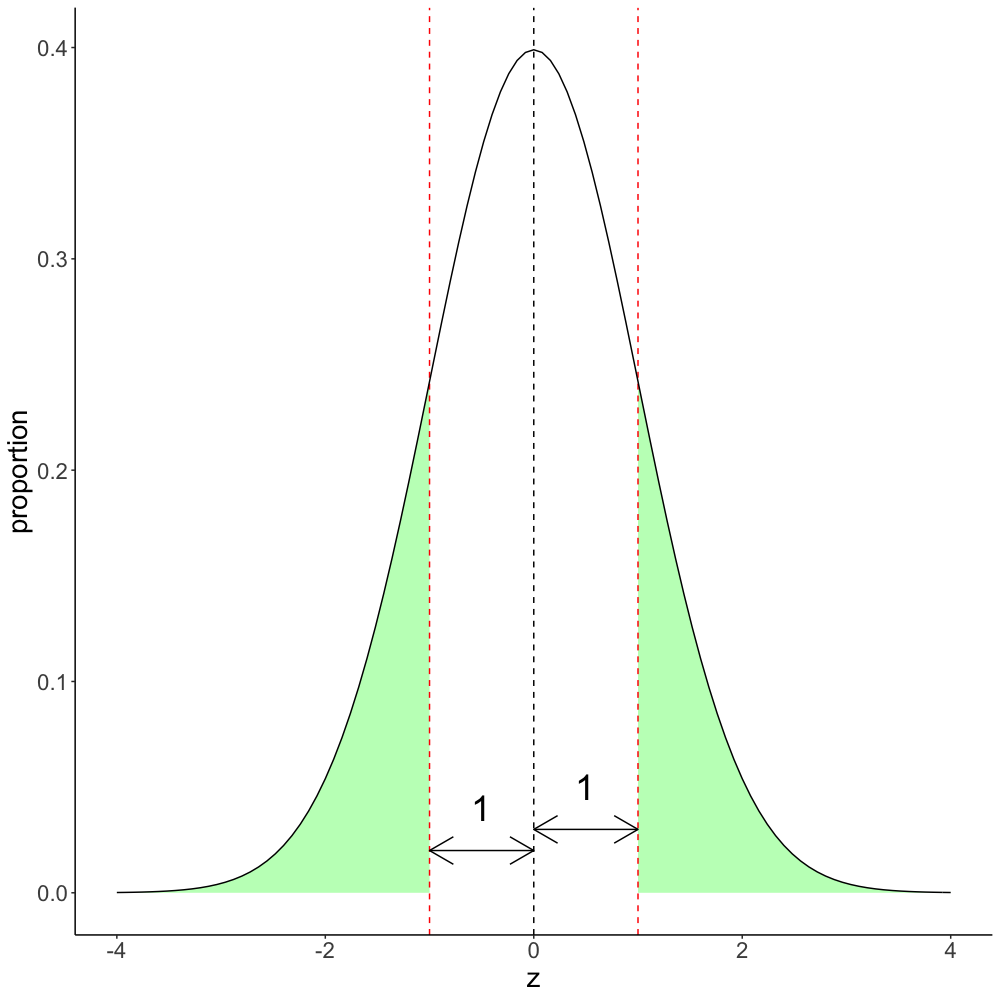

In [210]:
ggplot() + 
scale_x_continuous(limits=c(-4,4)) +

stat_function(fun = dnorm, fill = 'darkseagreen1', xlim = c(-4,-z), geom = "area") +
stat_function(fun = dnorm, fill = 'darkseagreen1', xlim = c(z,4), geom = "area") +

geom_vline(xintercept = 0, color = "black", linetype=2) +
geom_vline(xintercept = c((45-50)/5, (55-50)/5), color = "red", linetype=2) +
geom_segment(aes(x = -1, y = 0.02, xend = 0, yend = 0.02),arrow = arrow(length = unit(0.03, "npc"), ends = "both")) +
geom_segment(aes(x = 0, y = 0.03, xend = 1, yend = 0.03),arrow = arrow(length = unit(0.03, "npc"), ends = "both")) +
annotate("text", x = -0.5, y = 0.04, label = "1", size=9) +
annotate("text", x = 0.5, y = 0.05, label = "1", size=9) +
stat_function(fun = dnorm, args = list(mean = 0, sd = 1), color = 'black', size=0.5) +

labs(y="proportion", x = "z") + 
theme_classic() + 
theme(text = element_text(size=20))

In [120]:
2*pnorm(q = -1)

[1] 0.3173105

# 2. Bivariate circular normal distribution

## 2.1 Real world experiment to approximate the distribution

Let's flip 2 coins 100 times each and record the outcome:

In [121]:
set.seed(0)
table(sample(c('heads','tails'), size=100, p=c(0.5, 0.5), replace = TRUE))
table(sample(c('heads','tails'), size=100, p=c(0.5, 0.5), replace = TRUE))


heads tails 
   48    52 


heads tails 
   54    46 

Now let's repeat the above process 10,000 times and record the results. Here's what the first 3 out of 10,000 results look like:

In [122]:
set.seed(0)
m1 <- replicate(n = 10000, table(sample(c('c1.heads','c1.tails'), size=100, p=c(0.5, 0.5), replace = TRUE))) %>% t()
m2 <- replicate(n = 10000, table(sample(c('c2.heads','c2.tails'), size=100, p=c(0.5, 0.5), replace = TRUE))) %>% t()
m <- data.frame(m1, m2)

m %>% head(3)

,c1.heads,c1.tails,c2.heads,c2.tails
,<int>,<int>,<int>,<int>
1,48,52,46,54
2,54,46,46,54
3,38,62,51,49


## 2.2 Degrees of freedom

Similar to the last example, we can remove the tails data without losing any information about the system. This time, however, we have 2 coins vs 1, and so we have 2 degrees of freedom.

In [123]:
m <- m %>% select(c1.heads, c2.heads)
m %>% head(3)

,c1.heads,c2.heads
,<int>,<int>
1,48,46
2,54,46
3,38,51


## 2.3 Visualize the distribution

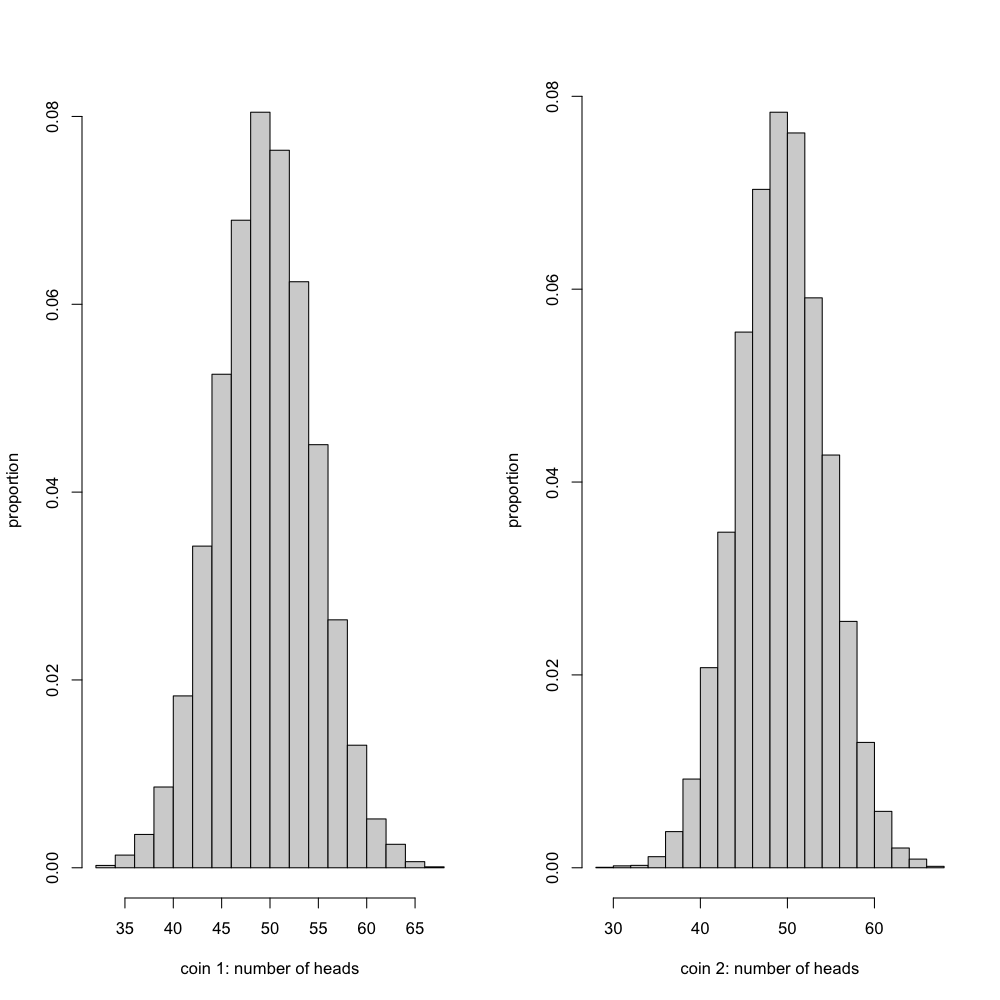

In [124]:
par(mfrow = c(1, 2))
hist(m %>% pull(c1.heads), freq = FALSE, main=NULL, xlab="coin 1: number of heads", ylab="proportion")
hist(m %>% pull(c2.heads), freq = FALSE, main=NULL, xlab="coin 2: number of heads", ylab="proportion")

Each distribution is again a binomial distribution with the following identical parameters:
- mean = 50
- se = $\sqrt{n*p*(1-p)} = \sqrt{100*0.5*1-(0.5)} = 5$

We can also plot both distributions on one graph - this is called <font color='red'>the bivariate normal distribution:</font>

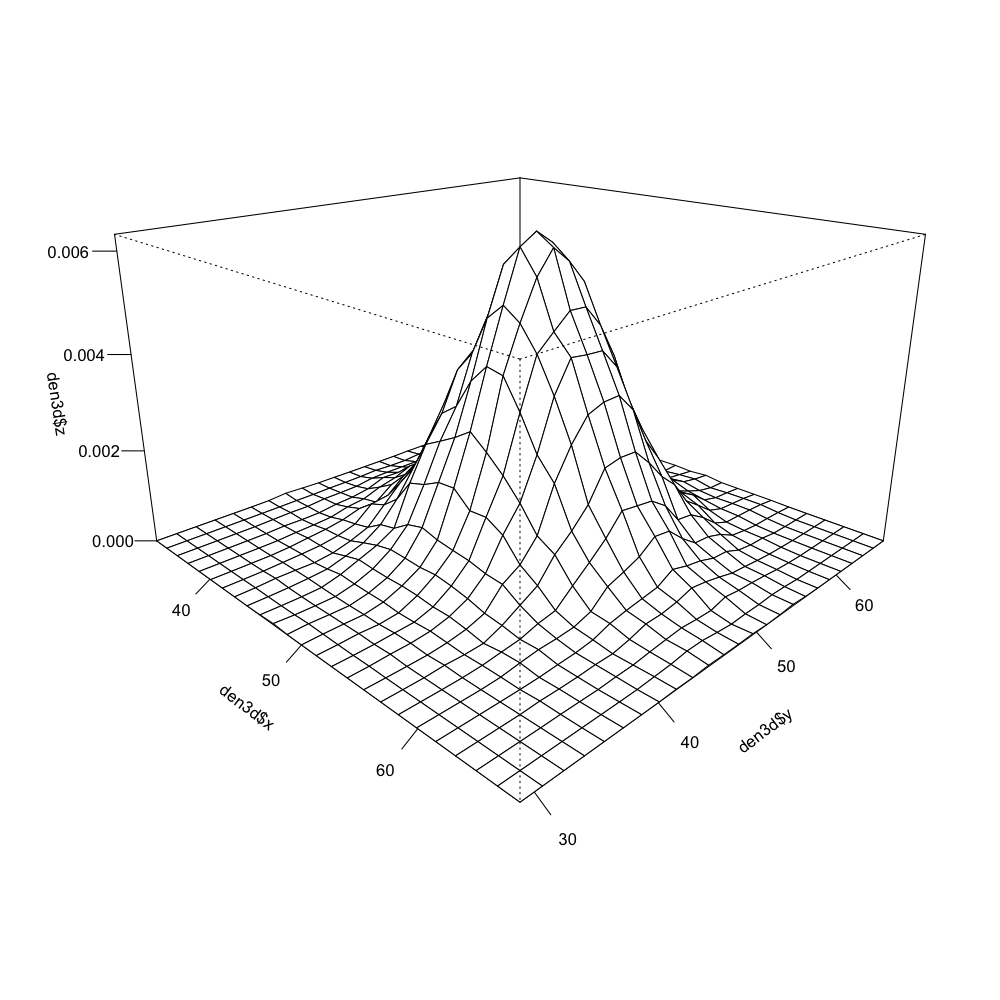

In [125]:
den3d <- kde2d(m$c1.heads, m$c2.heads)
persp(x=den3d$x, y=den3d$y, z=den3d$z, theta=45, phi=20, expand=0.6, ticktype='detailed', border = 'black', lwd=1)

## 2.4 Covariance matrix and correlation

In [126]:
cov(m)
cor(m)

,c1.heads,c2.heads
c1.heads,24.585168,0.290422
c2.heads,0.290422,25.299029


,c1.heads,c2.heads
c1.heads,1.00000000,0.01164504
c2.heads,0.01164504,1.00000000


## 2.5 Visualize a theoretical, continuous distribution

It's obvious from the 3D plot above that our distribution arising from simulation isn't quite smooth. As in the previous section, let's swap over to a continuous distribution.

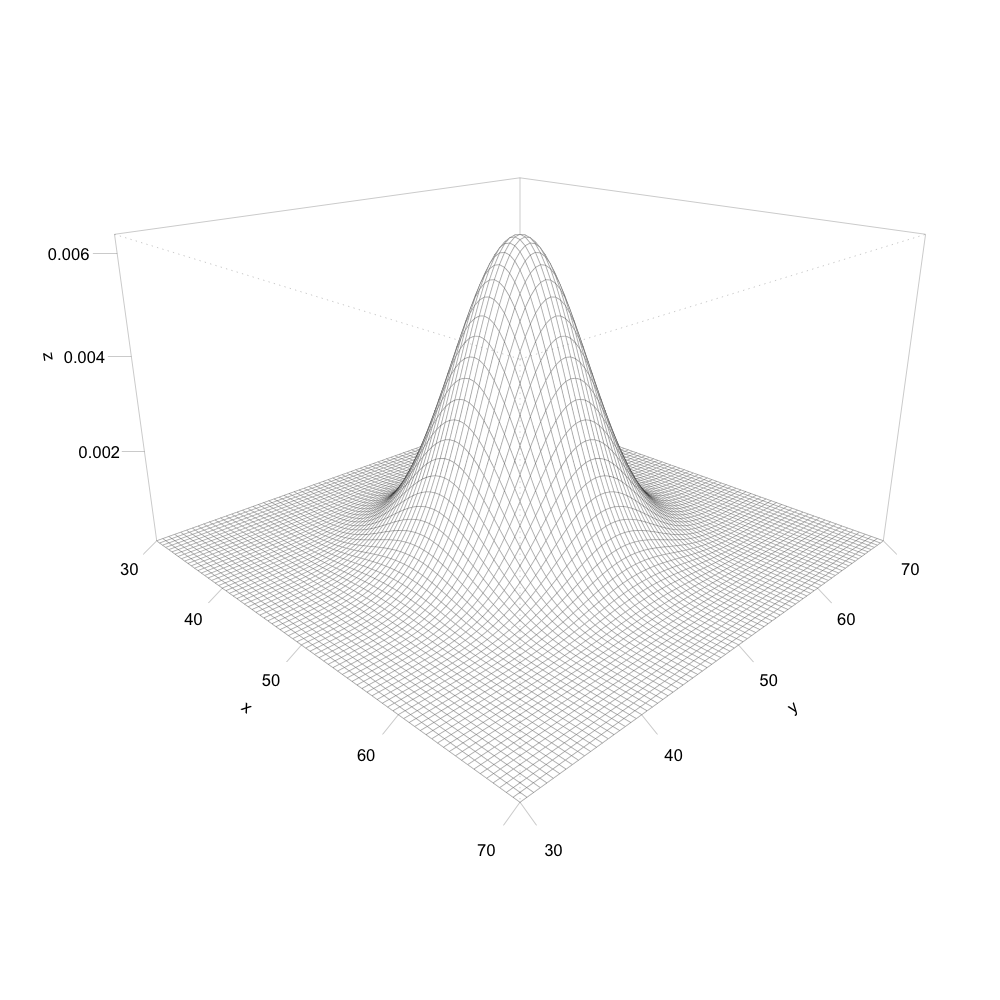

In [127]:
set.seed(0)

#create bivariate normal distribution
x     <- seq(30, 70, 0.5) 
y     <- seq(30, 70, 0.5)
mu    <- c(50, 50)
sigma <- matrix(c(25, 0, 0, 25), nrow=2)
f     <- function(x, y) dmnorm(cbind(x, y), mu, sigma)
z     <- outer(x, y, f)

#create surface plot
persp(x, y, z, theta=45, phi=20, expand=0.6, ticktype='detailed', border = 'black', lwd=0.2)

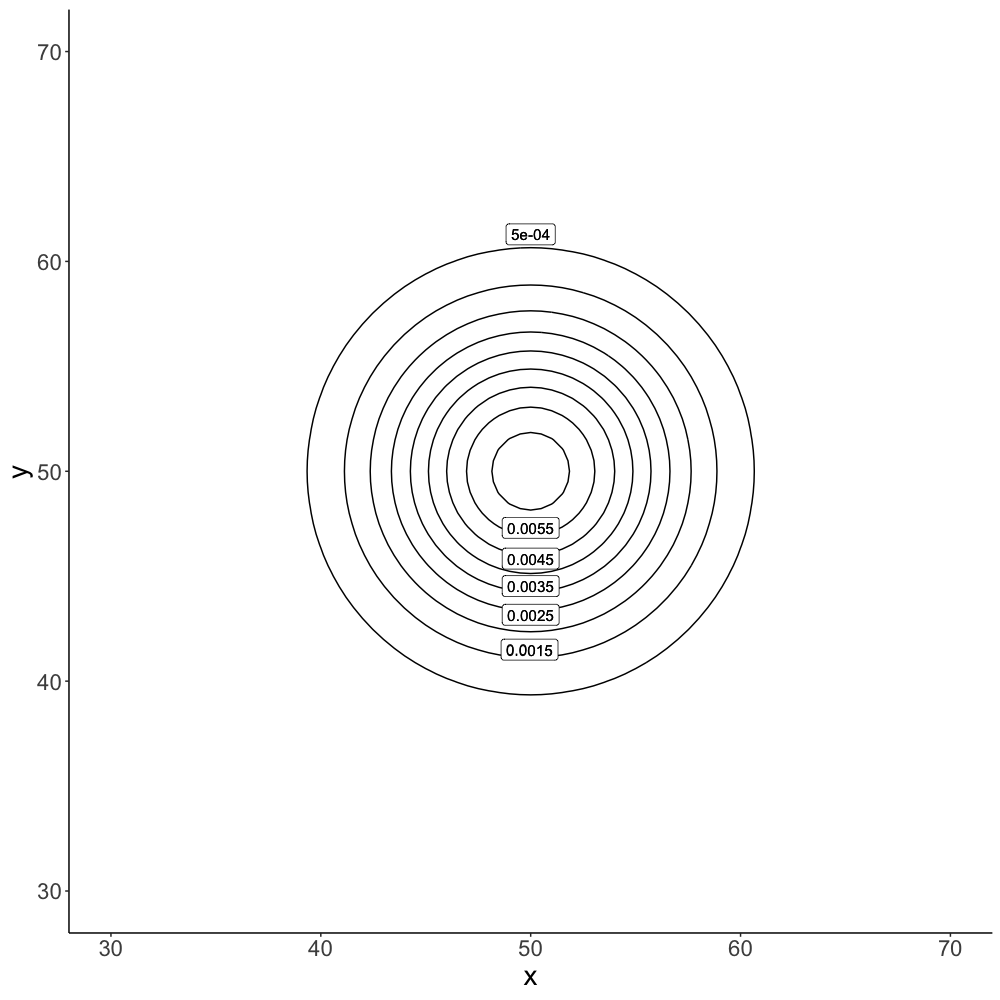

In [128]:
x     <- seq(30, 70, 0.5) 
y     <- seq(30, 70, 0.5)
data.grid <- expand.grid(x=x, y=y)
mu    <- c(50, 50)
sigma <- matrix(c(25, 0, 0, 25), nrow=2)
q.samp    <- cbind(data.grid, prob = mvtnorm::dmvnorm(data.grid, mean = mu, sigma = sigma))

ggplot(q.samp, aes(x, y, z=prob)) +   
    #ggforce::geom_circle(aes(x0 = 0, y0 = 0, r = 2), inherit.aes = FALSE, color = 'red', fill='white', data=data.frame()) +
    geom_contour(color='black', bins = 10) +
    coord_fixed(xlim = c(30, 70), ylim = c(30, 70), ratio = 1)  +
  geom_label_contour() +
geom_text_contour() + 
    theme_classic() + 
theme(text = element_text(size=20)) 

## 2.6 Choose a point in this space

Imagine that we wanted to understand the probability of getting a value at least as extreme as 45 heads from 100 flips of coin 1 and 45 heads from 100 flips of coin 2. Let's plot this point on the distribution.

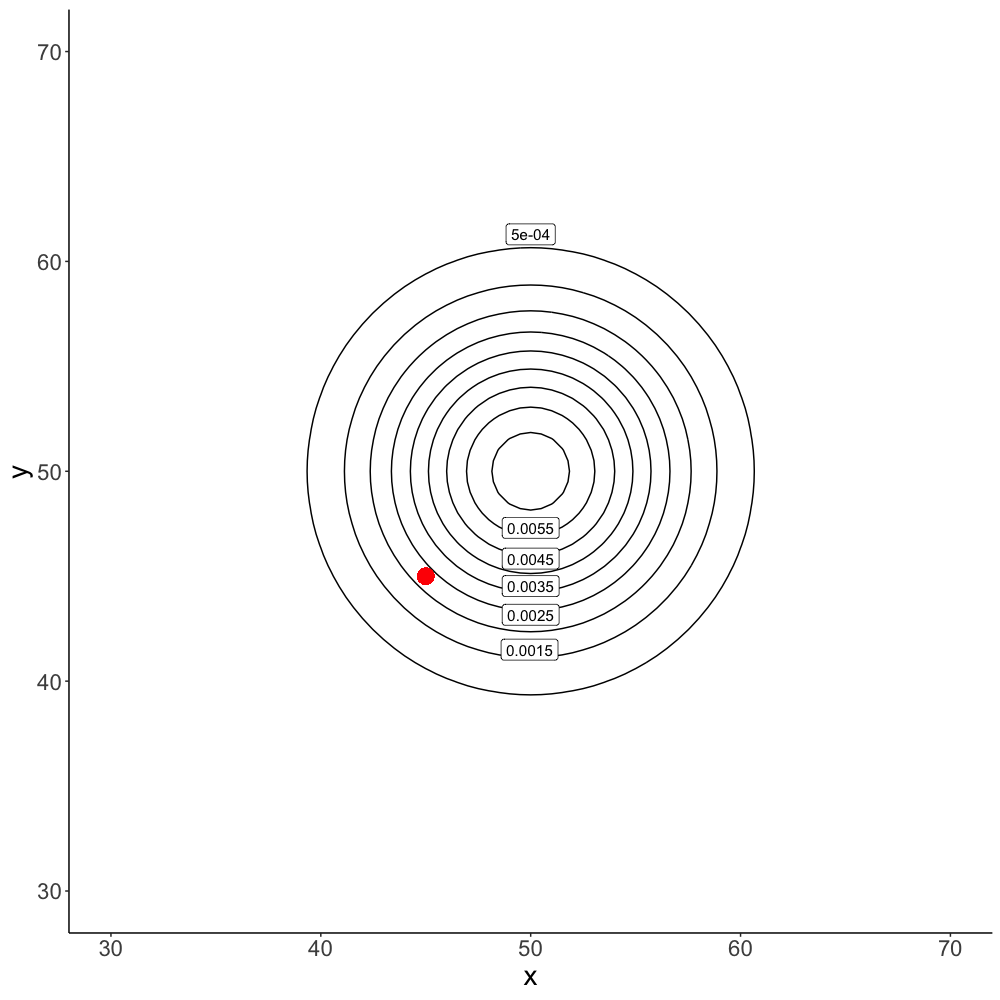

In [129]:
ggplot(q.samp, aes(x, y, z=prob)) +   
    #ggforce::geom_circle(aes(x0 = 0, y0 = 0, r = 2), inherit.aes = FALSE, color = 'red', fill='white', data=data.frame()) +
    geom_contour(color='black', bins = 10) +
    coord_fixed(xlim = c(30, 70), ylim = c(30, 70), ratio = 1)  +
  geom_label_contour() +
geom_point(aes(x=45, y=45), colour="red", size = 5) +

    theme_classic() + 
theme(text = element_text(size=20)) 

## 2.7 Standardize the distribution

Let's examine the standardized distribution:

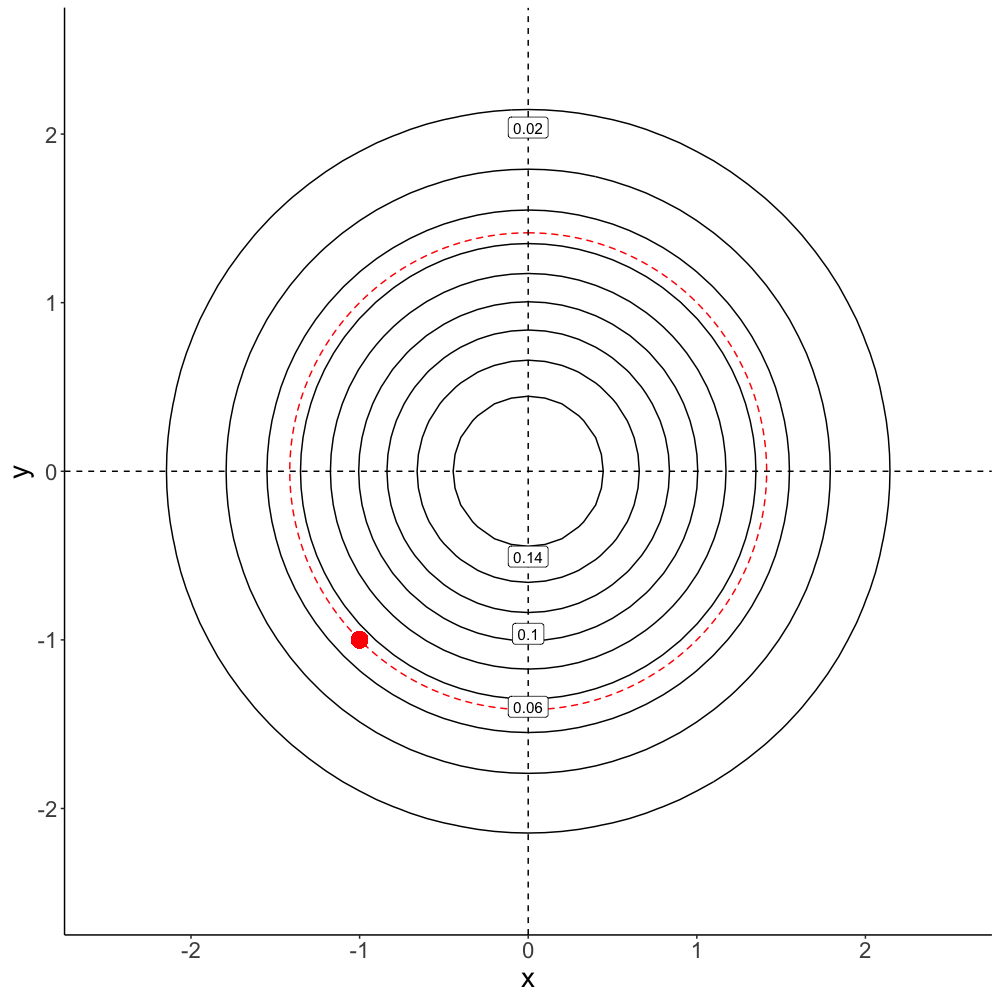

In [202]:
x     <- seq(-4, 4, 0.1) 
y     <- seq(-4, 4, 0.1)
data.grid <- expand.grid(x=x, y=y)
mu    <- c(0, 0)
sigma <- matrix(c(1, 0, 0, 1), nrow=2)
q.samp    <- cbind(data.grid, prob = mvtnorm::dmvnorm(data.grid, mean = mu, sigma = sigma))

ggplot(q.samp, aes(x, y, z=prob)) +   
    ggforce::geom_circle(aes(x0 = 0, y0 = 0, r = sqrt(2)), inherit.aes = FALSE, color = 'red', fill='white', data=data.frame(), linetype = 2) +
geom_vline(xintercept = 0, color = "black", linetype=2) +
geom_hline(yintercept = 0, color = "black", linetype=2) +
    geom_contour(color='black', bins = 10) +
    coord_fixed(xlim = c(-2.5, 2.5), ylim = c(-2.5,2.5), ratio = 1)  +
  geom_label_contour() +
geom_point(aes(x=(45-50)/5, y=(45-50)/5), colour="red", size = 5) +


    theme_classic() + 
theme(text = element_text(size=20)) 

## 2.8 Determine the test statistic

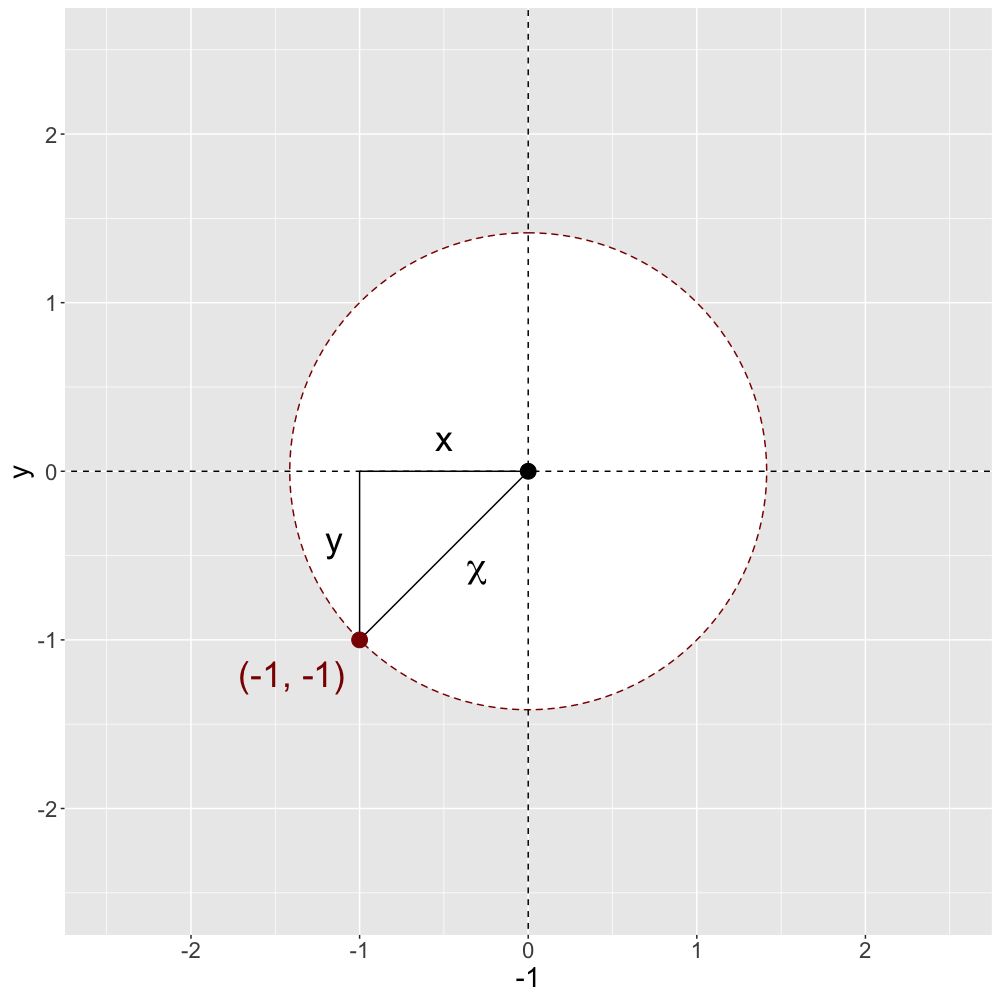

In [215]:
ggplot()  +
    coord_fixed(xlim = c(-2.5, 2.5), ylim = c(-2.5, 2.5), ratio = 1) +
    theme_classic()+


    #theme(panel.background = element_rect(fill='darkseagreen1')) +
    ggforce::geom_circle(aes(x0 = 0, y0 = 0, r = sqrt(1^2+1^2)), inherit.aes = FALSE, fill='white', color='darkred', linetype=2) +
    geom_contour(color='black', bins = 10) +
    geom_segment(aes(x = -1, y = 0, xend = -1, yend = -1)) +
    geom_segment(aes(x = 0, y = 0, xend = -1, yend = 0)) +
    geom_segment(aes(x = 0, y = 0, xend = -1, yend = -1)) +


geom_segment(aes(x = -4, y = 0, xend = 4, yend = 0), linetype = 2) +
geom_segment(aes(x = 0, y = -4, xend = 0, yend = 4), linetype = 2) +

    geom_point(aes(x=0, y=0), colour="black", size=5) +
    geom_point(aes(x=-1, y=-1), colour="darkred", size=5) +
    annotate("text", x = -0.5, y = 0.2, label = "x", size=9) +
    annotate("text", x = -1.15, y = -0.4, label = "y", size=9) +
    annotate("text", x = -0.3, y = -0.6, label = "chi", size=9, parse=TRUE) +
    annotate("text", x = -1.4, y = -1.2, label = "(-1, -1)", size=9, color='darkred') +

theme(text = element_text(size=20))


The point (-1, -1) is at a distance of $\chi$ from the coordinates of the expected mean (0, 0).

From the Pythagorean theorem we know that  $$\chi = \sqrt {x^2+y^2} $$

In other words: $$\chi^2=x^2+y^2$$

And plugging in the values of x and y we get: $$\chi^2=(-1)^2+(-1)^2=2$$

So, the probability of observing a point as extreme or more as (-1, -1) from this distribution = the proportion of data that is further away than $\chi^2$ from the expected mean.

In [118]:
z <- (50-45)/5
z

[1] 1

Let's overlay the test statistic on the standarized distribution: